In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings
from IPython import display

We'll continue to use the same datasets that we have been using throughout the course.

In [29]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [30]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

## LightGBM

LightGBM is a gradient boosting decision tree algorithm developed by Microsoft in 2017. LightGBM outperforms XGBoost in terms of compuational speed, and provides comparable accuracy in general. The following two key features in LightGBM that make it faster than XGBoost: 

**1. Gradient-based One-Side Sampling** (GOSS): Recall, in gradient boosting, we fit trees on the gradient of the loss function *(refer the gradient boosting algorithm in section 10.10.2 of the book, [Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/)):*

$$r_m = -\bigg[ \frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}  \bigg]_{f = f_{m-1}}. $$

Observations that correspond to relatively larger gradients contribute more to minimizing the loss function as compared to observations with smaller gradients. The algorithm down-samples the observations with small gradients, while selecting all the observations with large gradients. As observations with large gradients contribute the most to the reduction in loss function when considering a split, the accuracy of loss reduction estimate is maintained even with a reduced sample size. This leads to similar performance in terms of prediction accuracy while reducing computation speed due to reduction in sample size to fit trees.

**2. Exclusive feature bundling** (EFB): This is useful when there are a lot of predictors, but the predictor space is sparse, i.e., most of the values are zero for several predictors, and the predictors rarely take non-zero values simultaneously. This can typically happen in case of a lot of dummy variables in the data. In such a case, the predictors are bundled to create a single predictor. 

In the example below you can see that feature1 and feature2 are mutually exclusive. In order to achieve non overlapping buckets we add bundle size of feature1 to feature2. This makes sure that non zero data points of bundled features (feature1 and feature2) reside in different buckets. In feature_bundle buckets 1 to 4 contains non zero instances of feature1 and buckets 5,6 contain non zero instances of feature2 *([Reference](https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e))*. 

| feature1 | feature2 | feature_bundle |
| --- | --- | --- |
| 0 | 2 | 6 |
| 0 | 1 | 5 |
| 0 | 2 | 6 |
| 1 | 0 | 1 |
| 2 | 0 | 2 |
| 3 | 0 | 3 |
| 4 | 0 | 4 |

Read the [LightGBM paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) for more details.

### LightGBM for regression
Let us tune a lightGBM model for regression for our problem of predicting car price. We'll use the function [`LGBMRegressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html). For classification problems, [`LGBMClassifier`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) can be used. Note that we are using the GOSS algorithm to downsample observations with smaller gradients. 

In [31]:
#K-fold cross validation to find optimal parameters for LightGBM regressor
start_time = time.time()
param_grid = {'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=LGBMRegressor(boosting_type = 'goss'),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring='neg_root_mean_squared_error',
                             n_jobs=-1,random_state=1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation RMSE = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0, 'num_leaves': 20, 'n_estimators': 1000, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Optimal cross validation R-squared =  -5670.309021679375
Time taken =  1  minutes


In [32]:
#RMSE based on the optimal parameter values of a LighGBM Regressor model
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(Xtest),ytest))

5614.374498193448

Note that downsampling of small-gradient observations leads to faster execution time, but potentially by compromising some accuracy. We can expect to improve the accuracy by increasing the `top_rate` or the `other_rate` hyperparameters, but at an increased computational cost. In the cross-validation below, we have increased the `top_rate` to 0.5 from the default value of 0.2.

In [33]:
#K-fold cross validation to find optimal parameters for LightGBM regressor
start_time = time.time()
param_grid = {'num_leaves': [20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 1000],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=LGBMRegressor(boosting_type = 'goss', top_rate = 0.5),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring='neg_root_mean_squared_error',
                             n_jobs=-1,random_state=1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation RMSE = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 100, 'num_leaves': 31, 'n_estimators': 500, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Optimal cross validation R-squared =  -5436.062435616846
Time taken =  1  minutes


In [34]:
#RMSE based on the optimal parameter values of a LighGBM Regressor model
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(Xtest),ytest))

5355.964600884197

Note that the cross-validated RMSE has reduced. However, this is at an increased computational expense. In the simulations below, we compare the time taken to train models with increasing values of the `top_rate` hyperparameter.

In [92]:
time_list = []
for i in range(50):
    start_time = time.time()
    model = LGBMRegressor(boosting_type = 'goss', top_rate = 0.2, n_jobs=-1).fit(X, y)
    time_list.append(time.time()-start_time)

In [93]:
time_list2 = []
for i in range(50):
    start_time = time.time()
    model = LGBMRegressor(boosting_type = 'goss', top_rate = 0.5, n_jobs=-1).fit(X, y)
    time_list2.append(time.time()-start_time)

In [94]:
time_list3 = []
for i in range(50):
    start_time = time.time()
    model = LGBMRegressor(boosting_type = 'goss', top_rate = 0.8, n_jobs=-1).fit(X, y)
    time_list3.append(time.time()-start_time)

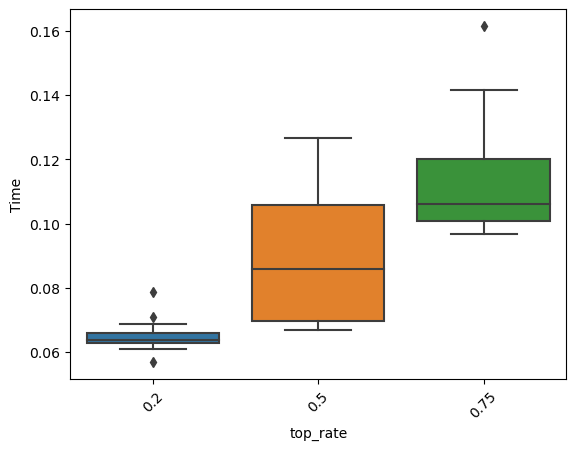

In [85]:
ax = sns.boxplot([time_list, time_list2, time_list3]);
ax.set_xticklabels([0.2, 0.5, 0.75]);
plt.ylabel('Time');
plt.xlabel('top_rate');
plt.xticks(rotation = 45);

### LightGBM vs XGBoost

LightGBM model took 2 minutes for a random search with 1000 fits as compared to 7 minutes for an XGBoost model with 1000 fits on the same data (as shown below). In terms of prediction accuracy, we observe that the accuracy of LightGBM on test *(unseen)* data is comparable to that of XGBoost.

In [14]:
#K-fold cross validation to find optimal parameters for XGBoost
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100],
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring = 'neg_root_mean_squared_error',
                             n_jobs=-1,random_state = 1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 100, 'colsample_bytree': 1.0}
Optimal cross validation R-squared =  -5178.8689594137295
Time taken =  7  minutes


In [15]:
#RMSE based on the optimal parameter values
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(Xtest),ytest))

5420.661056398766

## CatBoost

CatBoost is a gradient boosting algorithm developed by Yandex *(Russian Google)* in 2017. Like LightGBM, CatBoost is also faster than XGBoost in training. However, unlike LightGBM, the authors have claimed that it outperforms both LightGBM and XGBoost in terms of prediction accuracy as well. 

The key feature of CatBoost that address the issue with the gradient boosting procedure is the idea of ordered boosting. Classic boosting algorithms are prone to overfitting on small/noisy datasets due to a problem known as prediction shift. Recall, in gradient boosting, we fit trees on the gradient of the loss function *(refer the gradient boosting algorithm in section 10.10.2 of the book, [Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/)):*

$$r_m = -\bigg[ \frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}  \bigg]_{f = f_{m-1}}. $$

When calculating the gradient estimate of an observation, these algorithms use the same observations that the model was built with, thus having no chances of experiencing unseen data. CatBoost, on the other hand, uses the concept of ordered boosting, a permutation-driven approach to train model on a subset of data while calculating residuals on another subset, thus preventing "target leakage" and overfitting. The residuals of an observation are computed based on a model developed on the previous observations, where the observations are randomly shuffled at each iteration, i.e., for each tree.

Thus, the gradient of the loss function is based on test *(unseen)* data, instead of the data on which the model has been trained, which improves the generalizability of the model, and avoids overfitting on train data.

The authors have also shown that CatBoost performs better than XGBoost and LightGBM without tuning, i.e., with default hyperparameter settings.

Read the [CatBoost paper](https://proceedings.neurips.cc/paper_files/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf) for more details.

Here is a good [blog](https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm) listing the key features of CatBoost.

### CatBoost for regression

We'll use the function [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) for regression. For classification problems [CatBoostClassifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier) can be used.

Let us check the performance of `CatBoostRegressor()` without tuning, i.e., with default hyperparameter settings.

In [97]:
model_cat = CatBoostRegressor(verbose=0).fit(X, y)

In [103]:
cv = KFold(n_splits=5,shuffle=True,random_state=1)
np.mean(-cross_val_score(CatBoostRegressor(verbose=0), X, y, cv = cv, n_jobs = -1, 
                scoring='neg_root_mean_squared_error'))

5035.972129299527

In [99]:
np.sqrt(mean_squared_error(model_cat.predict(Xtest),ytest))

5288.82153844634

Even with default hyperparameter settings, CatBoost has outperformed both XGBoost and LightGBM in terms of cross-validated RMSE, and RMSE on test data for our example of predicting car prices.

### CatBoost vs XGBoost

Let us see the performance of XGBoost with default hyperparameter settings.

In [106]:
model_xgb = xgb.XGBRFRegressor().fit(X, y)
np.mean(-cross_val_score(xgb.XGBRFRegressor(), X, y, cv = cv, n_jobs = -1, 
                scoring='neg_root_mean_squared_error'))

6273.043859096154

In [107]:
np.sqrt(mean_squared_error(model_xgb.predict(Xtest),ytest))

6821.745153860935

XGBoost performance deteriorates showing that hyperparameter tuning is more important in XGBoost.

Let us see the performance of LightGBM with default hyperparameter settings.

In [112]:
model_lgbm = LGBMRegressor().fit(X, y)
np.mean(-cross_val_score(LGBMRegressor(), X, y, cv = cv, n_jobs = -1, 
                scoring='neg_root_mean_squared_error'))

5562.149251902867

In [113]:
np.sqrt(mean_squared_error(model_lgbm.predict(Xtest),ytest))

5494.0777923513515

LightGBM's default hyperparameter settings also seem to be more robust as compared to those of XGBoost.

### Tuning `CatBoostRegressor`

The CatBoost hyperparameters can be tuned just like the XGBoost hyperparameters. However, there is some difference in the hyperparameters of both the packages. For example, `reg_alpha` *(the L1 penalization on weights of leaves)* and `colsample_bytree` *(subsample ratio of columns when constructing each tree)* hyperparameters are not there in CatBoost.

In [121]:
#K-fold cross validation to find optimal parameters for CatBoost regressor
start_time = time.time()
param_grid = {'max_depth': [4,6,8, 10],
              'num_leaves': [20, 31, 40, 60],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[500, 1000, 1500],
                'subsample': [0.5, 0.75, 1.0],
             'colsample_bylevel': [0.25, 0.5, 0.75, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=CatBoostRegressor(random_state=1, verbose=False, 
                            grow_policy='Lossguide'),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,random_state = 1, scoring='neg_root_mean_squared_error',
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X,y)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation RMSE = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 0, 'num_leaves': 40, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bylevel': 0.75}
Optimal cross validation RMSE =  -4993.129407810791
Time taken =  23  minutes


In [122]:
#RMSE based on the optimal parameter values
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(Xtest),ytest))

5249.434282204398

It takes 2 minutes to tune CatBoost, which is higher than LightGBM and lesser than XGBoost. CatBoost falls in between LightGBM and XGBoost in terms of speed. However, it is likely to be more accurate than XGBoost and LighGBM, and likely to require lesser tuning as compared to XGBoost.

['colsample_bylevel', 'learning_rate', 'n_estimators', 'num_leaves', 'reg_lambda', 'subsample'] = [0.3745508446405472, 0.1000958551500621, 2000, 11, 0.0, 0.3877212027881348] 5132.537839676808


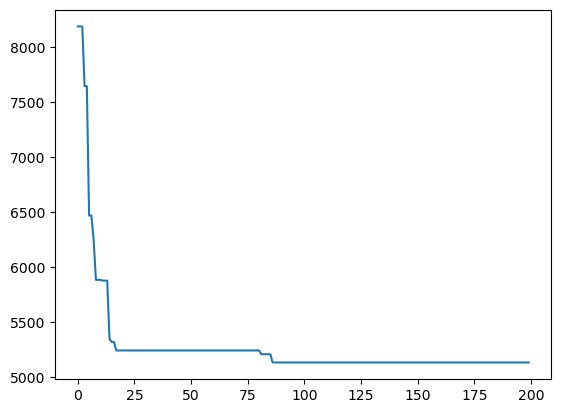

0:	learn: 15586.6547227	total: 7.88ms	remaining: 15.8s
1:	learn: 14594.4802869	total: 16.4ms	remaining: 16.4s
2:	learn: 14594.4802869	total: 17.2ms	remaining: 11.5s
3:	learn: 13743.4503923	total: 20.1ms	remaining: 10s
4:	learn: 13266.2414822	total: 24.9ms	remaining: 9.94s
5:	learn: 12498.3369959	total: 28.1ms	remaining: 9.33s
6:	learn: 12129.2561319	total: 30.3ms	remaining: 8.63s
7:	learn: 11505.6411010	total: 32.3ms	remaining: 8.03s
8:	learn: 11505.6411010	total: 32.7ms	remaining: 7.23s
9:	learn: 11021.2139091	total: 34.6ms	remaining: 6.89s
10:	learn: 10442.9678139	total: 37ms	remaining: 6.69s
11:	learn: 9947.6741148	total: 39.3ms	remaining: 6.51s
12:	learn: 9619.4595819	total: 41ms	remaining: 6.27s
13:	learn: 9259.8855899	total: 42.9ms	remaining: 6.08s
14:	learn: 9259.8855899	total: 43.4ms	remaining: 5.74s
15:	learn: 8939.7710703	total: 45.3ms	remaining: 5.62s
16:	learn: 8711.0852634	total: 47.3ms	remaining: 5.52s
17:	learn: 8604.6071027	total: 49.1ms	remaining: 5.41s
18:	learn: 8438

256:	learn: 4689.8119640	total: 377ms	remaining: 2.56s
257:	learn: 4689.8119640	total: 378ms	remaining: 2.55s
258:	learn: 4686.5896296	total: 380ms	remaining: 2.55s
259:	learn: 4680.2191721	total: 382ms	remaining: 2.56s
260:	learn: 4675.0591879	total: 385ms	remaining: 2.56s
261:	learn: 4671.5328062	total: 386ms	remaining: 2.56s
262:	learn: 4669.4746102	total: 388ms	remaining: 2.56s
263:	learn: 4666.6833477	total: 389ms	remaining: 2.56s
264:	learn: 4665.4037114	total: 391ms	remaining: 2.56s
265:	learn: 4663.4051577	total: 392ms	remaining: 2.56s
266:	learn: 4663.3353224	total: 393ms	remaining: 2.55s
267:	learn: 4660.7525508	total: 394ms	remaining: 2.55s
268:	learn: 4657.2685203	total: 396ms	remaining: 2.54s
269:	learn: 4657.2685203	total: 396ms	remaining: 2.54s
270:	learn: 4656.1503206	total: 397ms	remaining: 2.53s
271:	learn: 4652.0533288	total: 399ms	remaining: 2.54s
272:	learn: 4648.9435674	total: 401ms	remaining: 2.54s
273:	learn: 4645.7461085	total: 403ms	remaining: 2.54s
274:	learn

543:	learn: 4124.4222877	total: 742ms	remaining: 1.99s
544:	learn: 4124.4093974	total: 744ms	remaining: 1.99s
545:	learn: 4120.4906474	total: 745ms	remaining: 1.98s
546:	learn: 4120.1085313	total: 747ms	remaining: 1.98s
547:	learn: 4118.5497982	total: 748ms	remaining: 1.98s
548:	learn: 4118.5497982	total: 749ms	remaining: 1.98s
549:	learn: 4116.7736360	total: 750ms	remaining: 1.98s
550:	learn: 4114.8590115	total: 752ms	remaining: 1.98s
551:	learn: 4113.8718524	total: 754ms	remaining: 1.98s
552:	learn: 4113.6509912	total: 755ms	remaining: 1.97s
553:	learn: 4112.7943829	total: 756ms	remaining: 1.97s
554:	learn: 4112.7943829	total: 757ms	remaining: 1.97s
555:	learn: 4111.8971678	total: 758ms	remaining: 1.97s
556:	learn: 4108.7174163	total: 760ms	remaining: 1.97s
557:	learn: 4108.0979840	total: 762ms	remaining: 1.97s
558:	learn: 4107.4667399	total: 763ms	remaining: 1.97s
559:	learn: 4107.0891159	total: 765ms	remaining: 1.97s
560:	learn: 4106.3886713	total: 767ms	remaining: 1.97s
561:	learn

769:	learn: 3845.3032079	total: 1.11s	remaining: 1.77s
770:	learn: 3844.5649758	total: 1.11s	remaining: 1.77s
771:	learn: 3843.7347054	total: 1.11s	remaining: 1.77s
772:	learn: 3841.6978237	total: 1.11s	remaining: 1.77s
773:	learn: 3841.0971126	total: 1.12s	remaining: 1.77s
774:	learn: 3837.4084642	total: 1.12s	remaining: 1.77s
775:	learn: 3837.0934050	total: 1.12s	remaining: 1.76s
776:	learn: 3836.7762376	total: 1.12s	remaining: 1.76s
777:	learn: 3836.2799013	total: 1.12s	remaining: 1.76s
778:	learn: 3834.5565153	total: 1.12s	remaining: 1.76s
779:	learn: 3832.9932344	total: 1.13s	remaining: 1.76s
780:	learn: 3829.3338033	total: 1.13s	remaining: 1.76s
781:	learn: 3828.5601788	total: 1.13s	remaining: 1.76s
782:	learn: 3828.5601788	total: 1.13s	remaining: 1.76s
783:	learn: 3828.5601744	total: 1.13s	remaining: 1.75s
784:	learn: 3827.5366664	total: 1.13s	remaining: 1.75s
785:	learn: 3826.4151057	total: 1.13s	remaining: 1.75s
786:	learn: 3825.7586832	total: 1.14s	remaining: 1.75s
787:	learn

1001:	learn: 3647.4992176	total: 1.48s	remaining: 1.47s
1002:	learn: 3647.4992176	total: 1.48s	remaining: 1.47s
1003:	learn: 3645.5814467	total: 1.48s	remaining: 1.47s
1004:	learn: 3645.1610774	total: 1.48s	remaining: 1.47s
1005:	learn: 3645.1130043	total: 1.48s	remaining: 1.47s
1006:	learn: 3643.9491608	total: 1.48s	remaining: 1.46s
1007:	learn: 3641.4554180	total: 1.49s	remaining: 1.46s
1008:	learn: 3640.8504319	total: 1.49s	remaining: 1.46s
1009:	learn: 3640.7715577	total: 1.49s	remaining: 1.46s
1010:	learn: 3640.6094922	total: 1.49s	remaining: 1.46s
1011:	learn: 3638.4023054	total: 1.49s	remaining: 1.46s
1012:	learn: 3636.7756918	total: 1.49s	remaining: 1.46s
1013:	learn: 3635.7462844	total: 1.5s	remaining: 1.45s
1014:	learn: 3635.4468132	total: 1.5s	remaining: 1.45s
1015:	learn: 3635.3983898	total: 1.5s	remaining: 1.45s
1016:	learn: 3635.1676270	total: 1.5s	remaining: 1.45s
1017:	learn: 3634.6068208	total: 1.5s	remaining: 1.45s
1018:	learn: 3633.7610803	total: 1.5s	remaining: 1.45

1180:	learn: 3509.6869391	total: 1.84s	remaining: 1.27s
1181:	learn: 3507.4650152	total: 1.84s	remaining: 1.27s
1182:	learn: 3506.7078692	total: 1.84s	remaining: 1.27s
1183:	learn: 3504.7656726	total: 1.85s	remaining: 1.27s
1184:	learn: 3503.8159906	total: 1.85s	remaining: 1.27s
1185:	learn: 3503.8159906	total: 1.85s	remaining: 1.27s
1186:	learn: 3503.6273305	total: 1.85s	remaining: 1.27s
1187:	learn: 3503.6273305	total: 1.85s	remaining: 1.27s
1188:	learn: 3502.9832157	total: 1.85s	remaining: 1.26s
1189:	learn: 3502.7191578	total: 1.86s	remaining: 1.26s
1190:	learn: 3501.7102875	total: 1.86s	remaining: 1.26s
1191:	learn: 3501.6303065	total: 1.86s	remaining: 1.26s
1192:	learn: 3501.6303065	total: 1.86s	remaining: 1.26s
1193:	learn: 3500.2342721	total: 1.86s	remaining: 1.26s
1194:	learn: 3498.5046870	total: 1.87s	remaining: 1.26s
1195:	learn: 3497.4228105	total: 1.87s	remaining: 1.26s
1196:	learn: 3497.4228105	total: 1.87s	remaining: 1.25s
1197:	learn: 3496.7478212	total: 1.87s	remaining

1396:	learn: 3397.3032297	total: 2.2s	remaining: 949ms
1397:	learn: 3396.4413072	total: 2.2s	remaining: 947ms
1398:	learn: 3396.1246833	total: 2.2s	remaining: 946ms
1399:	learn: 3396.1246833	total: 2.2s	remaining: 944ms
1400:	learn: 3393.3386727	total: 2.2s	remaining: 943ms
1401:	learn: 3393.0818296	total: 2.21s	remaining: 941ms
1402:	learn: 3392.3444709	total: 2.21s	remaining: 940ms
1403:	learn: 3392.3188682	total: 2.21s	remaining: 938ms
1404:	learn: 3392.3180694	total: 2.21s	remaining: 936ms
1405:	learn: 3391.6507938	total: 2.21s	remaining: 934ms
1406:	learn: 3391.3211071	total: 2.21s	remaining: 933ms
1407:	learn: 3391.3199251	total: 2.21s	remaining: 931ms
1408:	learn: 3390.2805332	total: 2.22s	remaining: 930ms
1409:	learn: 3389.8258158	total: 2.22s	remaining: 928ms
1410:	learn: 3388.7130263	total: 2.22s	remaining: 927ms
1411:	learn: 3386.4266049	total: 2.22s	remaining: 925ms
1412:	learn: 3385.1734910	total: 2.22s	remaining: 924ms
1413:	learn: 3381.9668231	total: 2.23s	remaining: 923

1638:	learn: 3279.8859464	total: 2.56s	remaining: 564ms
1639:	learn: 3279.8859464	total: 2.56s	remaining: 563ms
1640:	learn: 3279.8832386	total: 2.56s	remaining: 561ms
1641:	learn: 3279.0485989	total: 2.56s	remaining: 559ms
1642:	learn: 3278.8821714	total: 2.57s	remaining: 558ms
1643:	learn: 3278.8711028	total: 2.57s	remaining: 556ms
1644:	learn: 3277.1513013	total: 2.57s	remaining: 555ms
1645:	learn: 3275.8510292	total: 2.57s	remaining: 553ms
1646:	learn: 3275.6650452	total: 2.57s	remaining: 552ms
1647:	learn: 3275.6650452	total: 2.57s	remaining: 550ms
1648:	learn: 3275.3498004	total: 2.58s	remaining: 548ms
1649:	learn: 3274.9740567	total: 2.58s	remaining: 547ms
1650:	learn: 3274.7822665	total: 2.58s	remaining: 545ms
1651:	learn: 3274.6167592	total: 2.58s	remaining: 544ms
1652:	learn: 3274.3646848	total: 2.58s	remaining: 542ms
1653:	learn: 3274.1047843	total: 2.58s	remaining: 541ms
1654:	learn: 3273.1818950	total: 2.59s	remaining: 539ms
1655:	learn: 3273.1252249	total: 2.59s	remaining

1877:	learn: 3191.1792680	total: 2.93s	remaining: 190ms
1878:	learn: 3191.0838705	total: 2.93s	remaining: 189ms
1879:	learn: 3190.8872837	total: 2.93s	remaining: 187ms
1880:	learn: 3190.8872837	total: 2.93s	remaining: 185ms
1881:	learn: 3190.3398846	total: 2.93s	remaining: 184ms
1882:	learn: 3190.3178516	total: 2.93s	remaining: 182ms
1883:	learn: 3190.3178516	total: 2.94s	remaining: 181ms
1884:	learn: 3190.3178516	total: 2.94s	remaining: 179ms
1885:	learn: 3190.1615305	total: 2.94s	remaining: 178ms
1886:	learn: 3189.2103039	total: 2.94s	remaining: 176ms
1887:	learn: 3188.4273779	total: 2.94s	remaining: 174ms
1888:	learn: 3188.4238113	total: 2.94s	remaining: 173ms
1889:	learn: 3188.2809772	total: 2.94s	remaining: 171ms
1890:	learn: 3187.9026207	total: 2.94s	remaining: 170ms
1891:	learn: 3187.7516608	total: 2.95s	remaining: 168ms
1892:	learn: 3187.0001016	total: 2.95s	remaining: 167ms
1893:	learn: 3186.8764795	total: 2.95s	remaining: 165ms
1894:	learn: 3186.1777226	total: 2.95s	remaining

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=<catboost.core.CatBoostRegressor object at 0x000001C05095EFD0>,
              n_iter=200, n_jobs=-1, random_state=1,
              scoring='neg_root_mean_squared_error',
              search_spaces={'colsample_bylevel': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.0001, high=1.0, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=2, high=2000, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=4, high=64, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0, high=10000.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize')})

In [126]:
model = CatBoostRegressor(grow_policy='Lossguide') 

grid = {'num_leaves': Integer(4, 64),
              'learning_rate': Real(0.0001, 1.0),
               'reg_lambda':Real(0, 1e4),
                'n_estimators':Integer(2, 2000),
                'subsample': Real(0.1,1.0),
                'colsample_bylevel': Real(0.1, 1.0)}

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
gcv = BayesSearchCV(model, search_spaces = grid, cv = kfold, n_iter = 200, random_state = 1,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1)
paras = list(gcv.search_spaces.keys())
paras.sort()

def monitor(optim_result):
    cv_values = pd.Series(optim_result['func_vals']).cummin()
    display.clear_output(wait = True)
    min_ind = pd.Series(optim_result['func_vals']).argmin()
    print(paras, "=", optim_result['x_iters'][min_ind], pd.Series(optim_result['func_vals']).min())
    sns.lineplot(cv_values)
    plt.show()
gcv.fit(X, y, callback = monitor)

### Tuning Tips 

Check the [documentation](https://catboost.ai/en/docs/references/training-parameters/common) for some tuning tips.

1. It is not recommended to use values greater than 64 for `num_leaves`, since it can significantly slow down the training process.

2. The maximum possible value of `max_depth` is 16.